## Задача классификации музыкального жанра
Необходимо определить (по набору предвычесленных характеристик) принадлежность музыкального трека к определенному музыкальному жанру (рассматривается 16 основных музыкальных жанров).

In [96]:
%matplotlib inline

import time
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as ipd
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import utils

In [97]:
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

В строчках таблица tracks содержится информация по каждому треку в отдельности. Она включает название песни, альбом, исполнителя, жанры, к которым относится трек. Также в таблице содержится пользовательская информация, например, избранные треки, альбомы и исполнители, количество воспроизведений трека и комментарии. В таблице есть список тегов, привязанных к конкретному треку, альбому и исполнителю, описание альбомов, биографии исполнителей.

In [98]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [99]:
tracks['album'].head()

,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


In [100]:
tracks['artist'].head()

,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


In [101]:
tracks['set'].head()

,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [102]:
tracks['track'].head()

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


Иерархия жанров была составлена на основе аннотации к треку (аннотации к треку были составлены самими исполнителями). Иерархия состоит из 161 жанра, из которых 16 являются основными, а остальные являются поджанрами.

In [103]:
genres

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
...,...,...,...,...
1032,60,102,Turkish,2
1060,30,46,Tango,2
1156,26,130,Fado,2


Все характеристики извлечены из треков с помощью библиотеки Librose (python библиотека для аналитики музыки и аудио). Каждый трек содержит 518 атрибутов, разбитых по 11 категориям, которые перечисленны ниже.

In [104]:
#features list
list(features.columns.levels[0])

['chroma_cens',
 'chroma_cqt',
 'chroma_stft',
 'mfcc',
 'rmse',
 'spectral_bandwidth',
 'spectral_centroid',
 'spectral_contrast',
 'spectral_rolloff',
 'tonnetz',
 'zcr']

Для каждой музыкальной характеристики вычисленны следующие параметры:

In [105]:
#each feature description
list(features.columns.levels[1])

['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']

In [106]:
features.head().style.format('{:.2f}')

Убеждаемся, что нет пропущенных значений

In [107]:
features.isna().sum()

feature      statistics  number
chroma_cens  kurtosis    01        0
                         02        0
                         03        0
                         04        0
                         05        0
                                  ..
zcr          mean        01        0
             median      01        0
             min         01        0
             skew        01        0
             std         01        0
Length: 518, dtype: int64

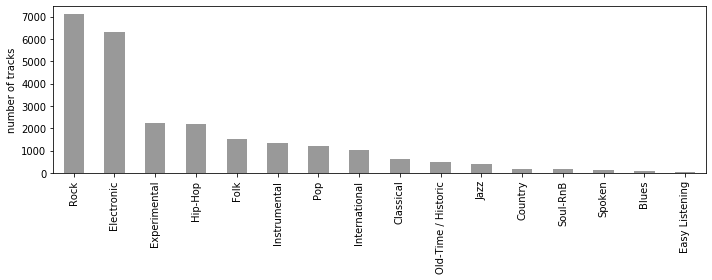

In [108]:
# Number of tracks per 16 root genres.
d = tracks[tracks['set', 'subset'] <= 'medium']
d = d['track', 'genre_top'].value_counts()
plt.figure(figsize=(10, 4))
d.plot.bar(color='k', alpha=0.4)
plt.ylabel('number of tracks')
plt.xlabel('')
plt.tight_layout()

count    25000.000000
mean       229.907960
std        102.230898
min         60.000000
25%        158.000000
50%        213.000000
75%        283.000000
max        600.000000
Name: (track, duration), dtype: float64

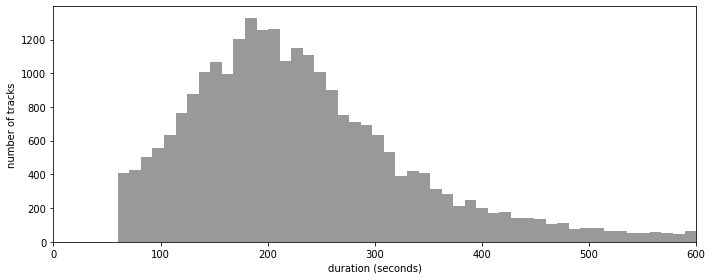

In [109]:
# Tracks durations.
t = tracks[tracks['set', 'subset'] <= 'medium']
durations = t['track', 'duration']
plt.figure(figsize=(10, 4))
p = sns.distplot(durations[durations.values < 800], kde=False, rug=False, color='k', hist_kws=dict(alpha=0.4))
p.set_xlabel('duration (seconds)')
p.set_ylabel('number of tracks')
p.set_xlim(0, 600)
plt.tight_layout()

durations.describe()

In [110]:
tracks['track', 'genre_top'].cat.categories.tolist()

['Blues',
 'Classical',
 'Country',
 'Easy Listening',
 'Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Jazz',
 'Old-Time / Historic',
 'Pop',
 'Rock',
 'Soul-RnB',
 'Spoken']

В целях увеличения быстродействия расчетов будем работать с датасетом меньшей размерности (25000 треков)

In [111]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((25000, 52), (25000, 518))

In [112]:
ft = pd.concat([features.loc[:, ('zcr', 'mean', '01')],
                features.loc[:, ('rmse', 'mean', '01')],
                features.loc[:, ('tonnetz', 'mean', '01')], tracks['track', 'genre_top']], axis=1, join='inner')
ft.columns = ['chroma_cens-mean-1', 'rmse-mean-1', 'tonnetz-mean-1', 'genre_top']

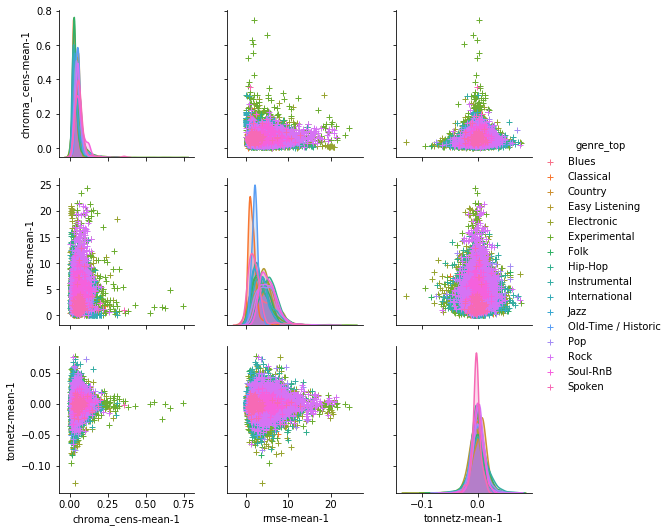

In [113]:
sns.pairplot(ft, plot_kws=dict(marker="+", linewidth=1), hue="genre_top");

In [114]:
ft = pd.concat([features.loc[:, ('mfcc', 'mean', slice('01','03'))], tracks['track', 'genre_top']], axis=1, join='inner')
ft.columns = ['mfcc-mean-1', 'mfcc-mean-2', 'mfcc-mean-3', 'genre_top']

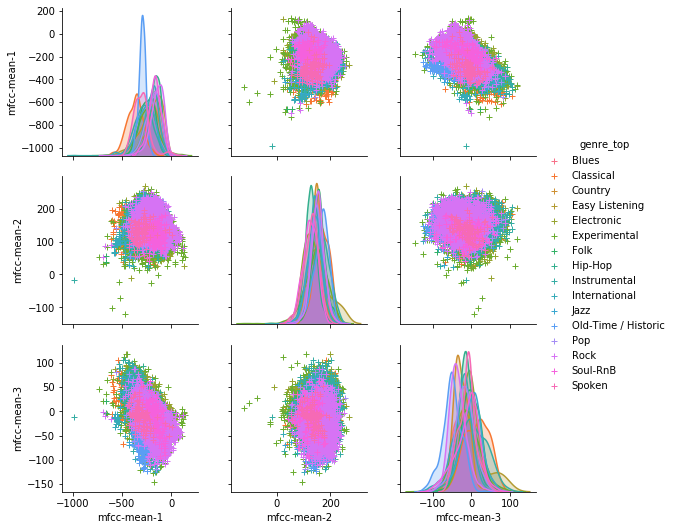

In [115]:
sns.pairplot(ft, plot_kws=dict(marker="+", linewidth=1), hue="genre_top");

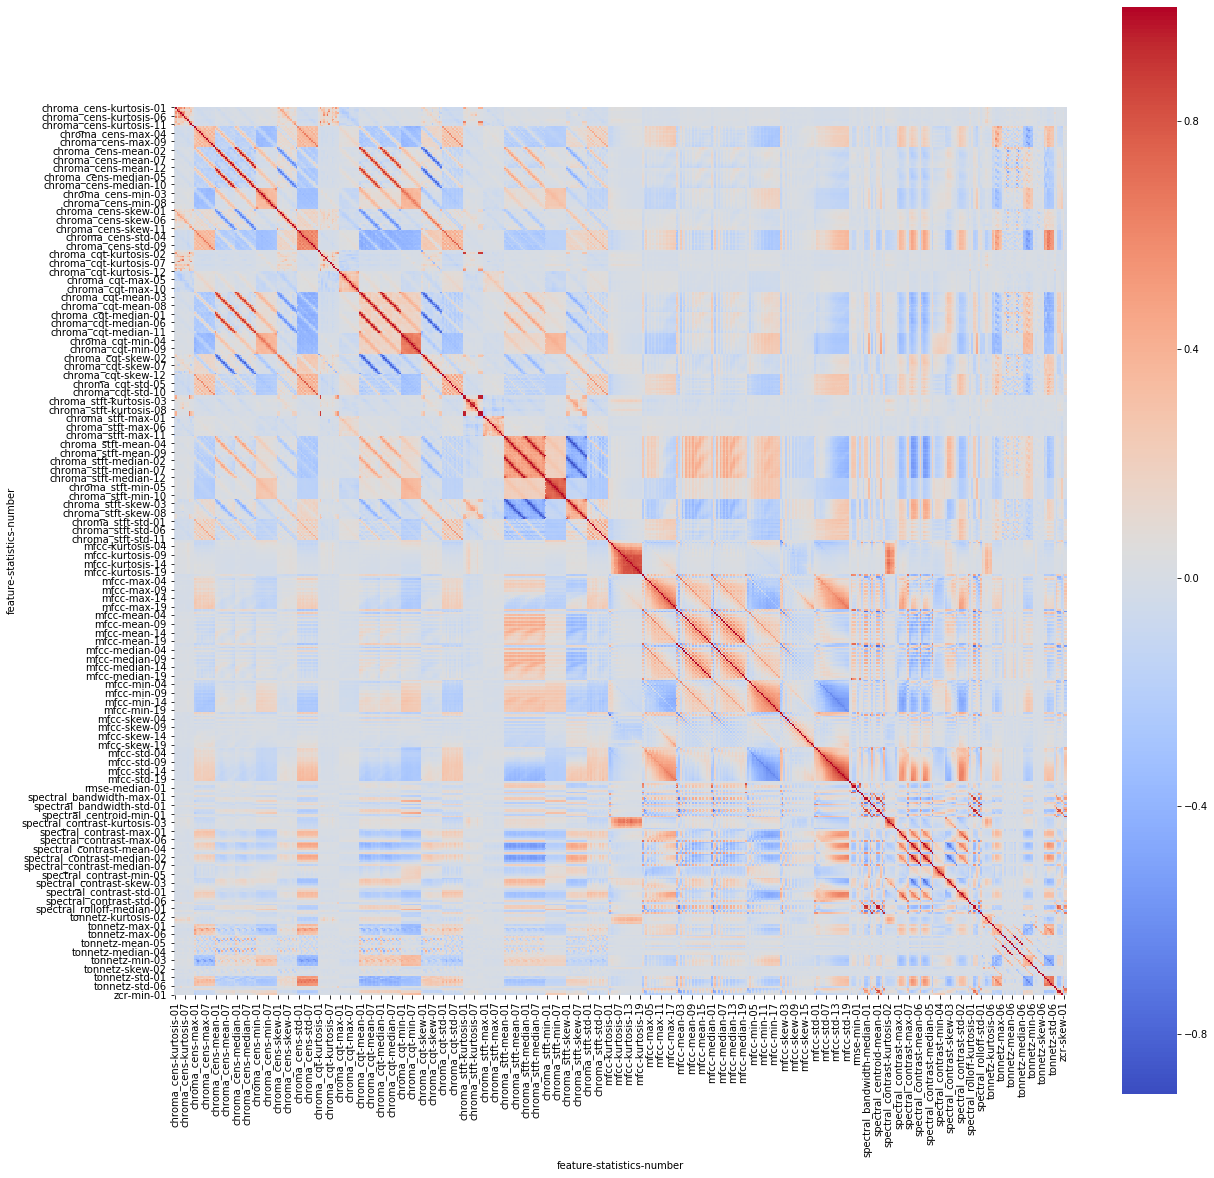

In [116]:
corr = features.corr()
plt.figure(figsize = (20,20))
sns.heatmap(corr, square=True, cmap='coolwarm');

FMA датасет сразу предлает раздделить на 80/10/10% тренировочную, валидационную и тестовую выборки.

In [117]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

19922 training examples, 2505 validation examples, 2573 testing examples


In [118]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns].as_matrix()
    X_val = features.loc[val, columns].as_matrix()
    X_test = features.loc[test, columns].as_matrix()
    
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

In [119]:
def test_classifiers_features(classifiers, feature_sets, features_all, multi_label=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
            t = time.process_time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
    return scores, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

In [120]:
classifiers = {
    'LR': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    'linSVC1': SVC(kernel="linear"),
    'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'SVCrbf': SVC(kernel='rbf'),
    #'SVCpoly1': SVC(kernel='poly', degree=1),
    #'linSVC2': LinearSVC(),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    #'DT': DecisionTreeClassifier(max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=10),
    #'MLP1': MLPClassifier(hidden_layer_sizes=(100,), max_iter=2000),
    #'MLP2': MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=2000),
    #'NB': GaussianNB(),
    #'QDA': QuadraticDiscriminantAnalysis(),
}

feature_sets = {
#    'echonest_audio': ('echonest', 'audio_features'),
#    'echonest_social': ('echonest', 'social_features'),
#    'echonest_temporal': ('echonest', 'temporal_features'),
#    'echonest_audio/social': ('echonest', ('audio_features', 'social_features')),
#    'echonest_all': ('echonest', ('audio_features', 'social_features', 'temporal_features')),
}
for name in features.columns.levels[0]:
    feature_sets[name] = name

feature_sets.update({
#    'mfcc/contrast': ['mfcc', 'spectral_contrast'],
#    'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
#    'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
#    'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
#    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
#    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})

In [121]:
#fit model
scores, times = test_classifiers_features(classifiers, feature_sets, features_all);

In [122]:
#display scores and times
ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

,dim,LR,kNN,linSVC1,RF,SVCrbf,AdaBoost
chroma_cens,84,39.33%,37.50%,39.29%,33.42%,42.29%,30.86%
chroma_cqt,84,40.42%,40.03%,41.39%,36.61%,44.27%,35.72%
chroma_stft,84,44.00%,43.92%,44.35%,38.32%,48.31%,35.25%
mfcc,140,58.03%,54.99%,59.19%,45.51%,60.98%,41.31%
rmse,7,36.81%,38.52%,37.54%,36.61%,38.90%,34.67%
spectral_bandwidth,7,40.61%,45.39%,40.42%,43.84%,44.46%,37.47%
spectral_centroid,7,42.79%,45.36%,42.09%,43.37%,45.71%,42.60%
spectral_contrast,49,51.61%,49.55%,51.81%,43.37%,54.45%,39.53%
spectral_rolloff,7,41.86%,46.25%,41.62%,45.39%,47.53%,41.66%
tonnetz,42,40.11%,37.31%,40.15%,36.11%,42.25%,34.16%


,LR,kNN,linSVC1,RF,SVCrbf,AdaBoost
chroma_cens,4.4688,12.1875,250.8281,0.1406,93.3125,2.5781
chroma_cqt,5.2344,13.2500,340.0781,0.1250,89.0938,2.4062
chroma_stft,5.6719,11.5781,232.0938,0.1250,80.4531,2.3125
mfcc,8.6250,20.6250,219.7656,0.1562,95.0469,4.6250
rmse,2.1719,0.5781,17.6719,0.1250,25.1406,0.3281
spectral_bandwidth,2.2500,0.4844,20.9062,0.1250,23.7188,0.3281
spectral_centroid,2.3438,0.4531,23.7656,0.1250,20.9531,0.3281
spectral_contrast,3.8125,7.6406,78.7031,0.1406,40.0312,1.6406
spectral_rolloff,2.2656,0.4688,21.4531,0.1094,21.9531,0.2812
tonnetz,3.8750,6.4375,84.6875,0.1406,49.1875,1.4375


Была протестирована задача классификации музыкального жанра по каждой из представленных в датасете характеристиик. Наилучшим образом показал себя метод опорных векторов (SVM) с ядром RBF. Этот метод обогнал по точности только метод k-ближайших соседей (k=200) при классификации с характеристикой "spectral_bandwidth".
Из второй таблицы, в которой показано время работы каждого метода в секундах, можно сделать вывод, что всех выстрей отработал метод случайный лес (RF), показав немного худшую точность.

### PCA

In [127]:
features_medium = features.loc[subset]

In [128]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_medium)

In [129]:
features_pca

array([[ 1259.70421593,   295.33172785],
       [ 1916.65113036,  -586.45576607],
       [  641.68788753,    20.86893571],
       ...,
       [-1565.16100786,  -425.71921026],
       [ 1161.5647938 ,   217.73052661],
       [-1017.97394149,  1297.11287749]])

In [130]:
features_pca_df = pd.DataFrame(data=features_pca)
features_pca_df.index = features.loc[subset].index
features_pca_df.columns = ['feature_1', 'feature_2']

In [131]:
features_pca_df_with_label = pd.concat([features_pca_df, tracks['track', 'genre_top']], axis=1, join='inner')
features_pca_df_with_label.columns = ['feature_1', 'feature_2', 'genre_top']
features_pca_df_with_label

,feature_1,feature_2,genre_top
track_id,,,
2,1259.704216,295.331728,Hip-Hop
3,1916.651130,-586.455766,Hip-Hop
5,641.687888,20.868936,Hip-Hop
10,78.792905,-720.742066,Pop
134,-146.895856,-50.862487,Hip-Hop
...,...,...,...
155297,-1175.857672,-3068.817198,Instrumental
155298,-1295.707293,-1358.707514,Folk
155306,-1565.161008,-425.719210,Folk


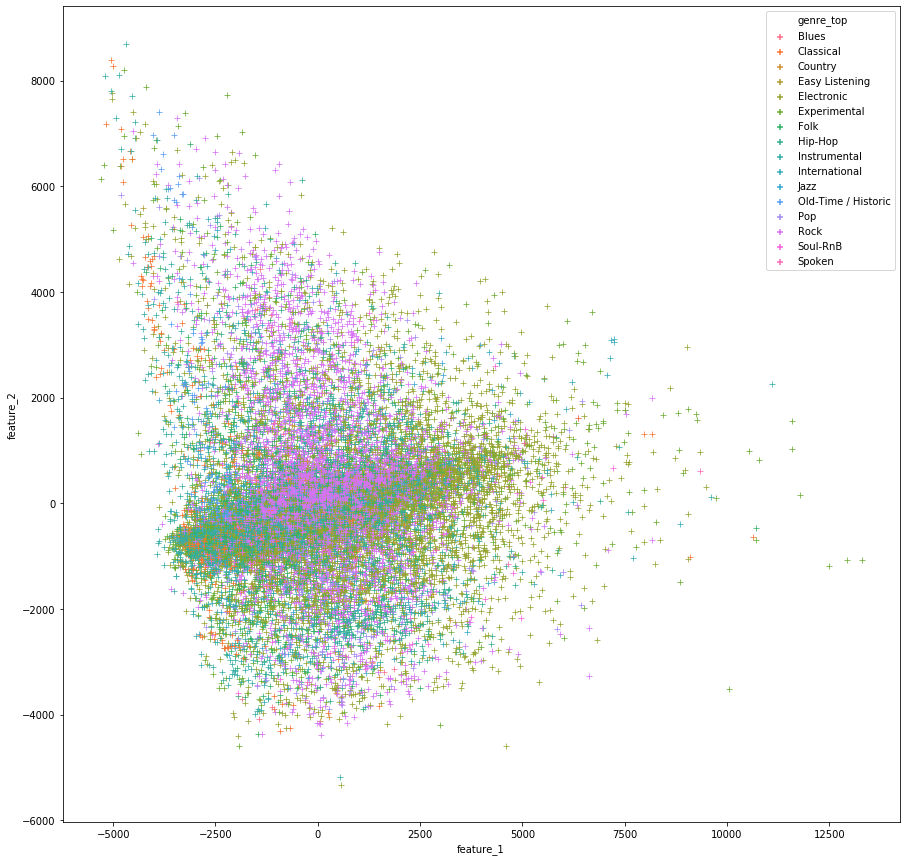

In [132]:
plt.figure(figsize = (15,15))

markers = {'Blues': "+",
     'Classical': "+",
     'Country': "+",
     'Easy Listening': "+",
     'Electronic': "+",
     'Experimental': "+",
     'Folk': "+",
     'Hip-Hop': "+",
     'Instrumental': "+",
     'International': "+",
     'Jazz': "+",
     'Old-Time / Historic': "+",
     'Pop': "+",
     'Rock': "+",
     'Soul-RnB': "+",
     'Spoken': "+"
}

sns.scatterplot(data=features_pca_df_with_label, x="feature_1", y="feature_2", hue="genre_top", style="genre_top", markers=markers);

In [133]:
scores, times = test_classifiers_features({'SVCrbf': SVC(kernel='rbf')},
                                          {'features_pca': ['feature_1', 'feature_2']},
                                          features_pca_df
                                         );

In [134]:
ipd.display(format_scores(scores))

,dim,SVCrbf
features_pca,2,36.03%


### PCA vs LDA

Построим графики зависимости ошибки на тестовой выборке и обучающей выборке в зависимости от количества используемых компонент

In [135]:
pca_err_train_mas = []
pca_err_test_mas = []

for n_comp in range(2, 12):
    pca = PCA(n_components=n_comp)
    features_pca = pca.fit_transform(features_medium)
    
    features_pca_df = pd.DataFrame(data=features_pca)
    features_pca_df.index = features.loc[subset].index
    columns = ["feature_" + str(i) for i in range(2, n_comp + 2)]
    features_pca_df.columns = columns
    
    y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_pca_df, columns)
    
    svc = SVC(kernel='rbf').fit(X_train, y_train)
    
    pca_err_train_mas.append(svc.score(X_train, y_train))
    pca_err_test_mas.append(svc.score(X_test, y_test))

In [136]:
print(pca_err_train_mas)

[0.3738078506174079, 0.4512599136632868, 0.460646521433591, 0.46777431984740486, 0.486346752334103, 0.497590603353077, 0.5057725127999196, 0.5150587290432688, 0.5379479971890373, 0.5452263828932838]


In [137]:
lda_err_train_mas = []
lda_err_test_mas = []

for n_comp in range(2, 12):
    labels = tracks['track', 'genre_top']
    y = enc.fit_transform(labels)
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    features_lda = lda.fit_transform(features_medium, y)
    
    features_lda_df = pd.DataFrame(data=features_lda)
    features_lda_df.index = features.loc[subset].index
    columns = ["feature_" + str(i) for i in range(2, n_comp + 2)]
    features_lda_df.columns = columns
    
    y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_lda_df, columns)
    
    svc = SVC(kernel='rbf').fit(X_train, y_train)
    
    lda_err_train_mas.append(svc.score(X_train, y_train))
    lda_err_test_mas.append(svc.score(X_test, y_test))

    pca_err_train  pca_err_test  lda_err_train  lda_err_test
2        0.373808      0.360280       0.529063      0.517295
3        0.451260      0.444617       0.564702      0.555771
4        0.460647      0.460941       0.629003      0.606296
5        0.467774      0.464827       0.649132      0.617567
6        0.486347      0.474543       0.670515      0.630781
7        0.497591      0.471823       0.686176      0.654100
8        0.505773      0.485426       0.694910      0.661485
9        0.515059      0.488535       0.698825      0.672756
10       0.537948      0.496308       0.708865      0.678197
11       0.545226      0.501749       0.711876      0.671978


[Text(0, 0.5, 'точность модели'), Text(0.5, 0, 'количество компонент')]

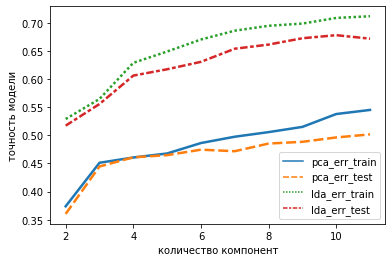

In [139]:
data = pd.DataFrame({
                     'pca_err_train': pca_err_train_mas,
                     'pca_err_test': pca_err_test_mas,
                     'lda_err_train': lda_err_train_mas,
                     'lda_err_test': lda_err_test_mas
                    },
                    index=range(2, 12))
print(data)
format_scores(data)
ax = sns.lineplot(data=data, palette="tab10", linewidth=2.5);
ax.set(xlabel='количество компонент', ylabel='точность модели')

Из полученных результатов следует, что PCA не позволяет снизить ошибку. В тоже время LDA позволяет снизить ошибку (точность повышается на 10%, если брать количество компонент около 10).